In [64]:
# Install and import necessary packages and libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # filter out INFO logs
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns


# Version information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Keras version:", tf.keras.__version__)

Num GPUs Available:  1
NumPy version: 1.19.5
Pandas version: 1.3.5
Matplotlib version: 3.5.3
Keras version: 2.5.0


In [53]:
# Version information
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Keras version:", tf.keras.__version__)

NumPy version: 1.19.5
Pandas version: 1.3.5
Matplotlib version: 3.5.3
Keras version: 2.5.0


In [54]:
# Data loading, pre-processing, and exploration

# Load the dataset
with open('data/emnist_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('data/emnist_test.pkl', 'rb') as f:
    test_data = pickle.load(f)

X_train = train_data['data']
y_train = train_data['labels']

X_test = test_data['data']
y_test = test_data['labels']

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (100000, 28, 28)
Training labels shape: (100000,)
Test data shape: (20000, 28, 28)
Test labels shape: (20000,)


In [55]:
# Reshape the data
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
num_classes = 62
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

In [19]:


def preprocess_data(X, y):

    # Reshape images
    # Current shape is (num_samples, 1, 28, 28)
    # We want (num_samples, 28, 28, 1) for Conv2D layers
    X = X.reshape(X.shape[0], 28, 28, 1)
    
    # Normalize pixel values to be between 0 and 1
    X = X.astype('float32') / 255.0
    
    # Verify the shape after preprocessing
    print(f"Preprocessed data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    return X, y
    
X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)



Preprocessed data shape: (100000, 28, 28, 1)
Labels shape: (100000,)
Preprocessed data shape: (20000, 28, 28, 1)
Labels shape: (20000,)


In [49]:
# One-hot encoding the labels

num_classes = 62  # EMNIST has 62 classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("\nAfter one-hot encoding:")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


After one-hot encoding:
y_train shape: (100000, 62)
y_test shape: (20000, 62)


In [27]:
# Create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("\nAfter creating validation set:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


After creating validation set:
X_train shape: (80000, 28, 28, 1)
y_train shape: (80000, 62, 62)
X_val shape: (20000, 28, 28, 1)
y_val shape: (20000, 62, 62)
X_test shape: (20000, 28, 28, 1)
y_test shape: (20000, 62, 62)


In [29]:
# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Fit the datagen on the training data
datagen.fit(X_train)

print("\nData augmentation generator is ready to use during model training.")


Data augmentation generator is ready to use during model training.


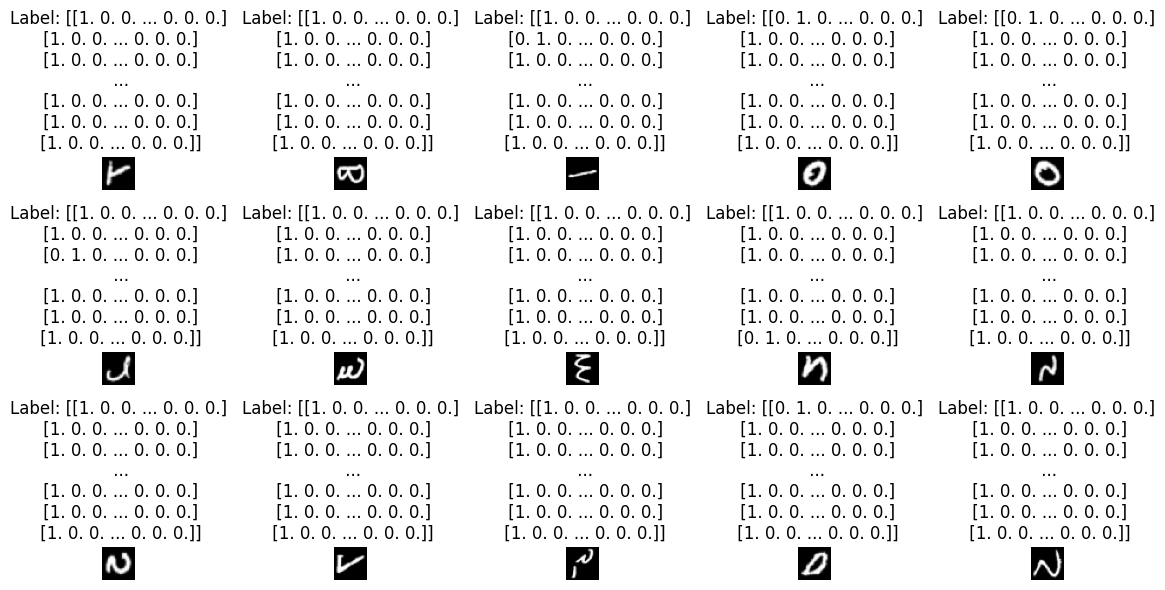

In [30]:
# Visualize some samples from the dataset
fig, axes = plt.subplots(3, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(15):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

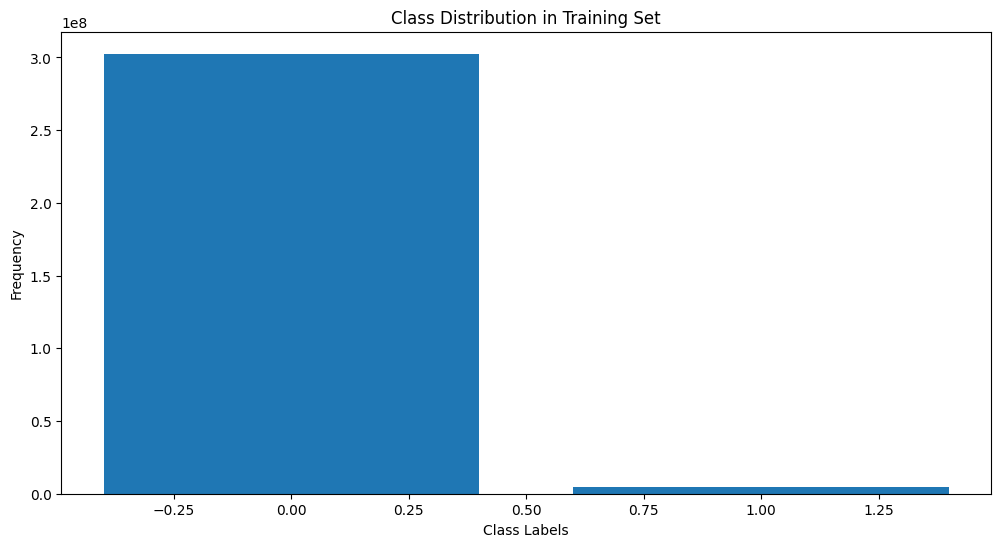

In [33]:
# Check class distribution in the training set
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique, counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.show()

In [56]:
# Model Implementation

# Model: Convolutional Neural Network (CNN)

model_cnn = Sequential()

# Convolutional Layer 1
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())

# Convolutional Layer 2
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())

# Flatten and Dense Layers
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 5, 5, 64)          256       
_________________________________________________________________
flatten_28 (Flatten)         (None, 1600)            

In [57]:
# Hyperparameter tuning for the CNN model
# Function to create model, required for KerasClassifier
def create_cnn_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Wrap the model using the function you have created
model_cnn_cv = KerasClassifier(build_fn=create_cnn_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [64, 128],
    'epochs': [5],  # Set to a low number for demonstration purposes
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5]
}

# Create Grid Search
grid = GridSearchCV(estimator=model_cnn_cv, param_grid=param_grid, n_jobs=1, cv=3)

# Fit the grid search
# Note: This process will take a considerable amount of time
grid_result = grid.fit(X_train, y_train_encoded)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.843480 using {'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 5, 'optimizer': 'adam'}


In [58]:
# Extract the best parameters
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

# Create a new model with the best parameters
model_cnn_best = create_cnn_model(optimizer=best_params['optimizer'], dropout_rate=best_params['dropout_rate'])

# Train the model with the training data
history_cnn = model_cnn_best.fit(
    X_train, y_train_encoded,
    batch_size=best_params['batch_size'],
    epochs=10,  # Increase the number of epochs for better performance
    validation_split=0.1,
    verbose=1
)


Best Parameters: {'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 5, 'optimizer': 'adam'}
Epoch 1/10
704/704 [==============================] - 9s 13ms/step - loss: 0.8978 - accuracy: 0.7372 - val_loss: 0.5339 - val_accuracy: 0.8276
Epoch 2/10
704/704 [==============================] - 8s 12ms/step - loss: 0.5484 - accuracy: 0.8141 - val_loss: 0.4684 - val_accuracy: 0.8413
Epoch 3/10
704/704 [==============================] - 8s 12ms/step - loss: 0.4825 - accuracy: 0.8325 - val_loss: 0.4609 - val_accuracy: 0.8396
Epoch 4/10
704/704 [==============================] - 8s 12ms/step - loss: 0.4487 - accuracy: 0.8413 - val_loss: 0.4326 - val_accuracy: 0.8470
Epoch 5/10
704/704 [==============================] - 8s 12ms/step - loss: 0.4181 - accuracy: 0.8496 - val_loss: 0.4283 - val_accuracy: 0.8510
Epoch 6/10
704/704 [==============================] - 8s 12ms/step - loss: 0.3953 - accuracy: 0.8544 - val_loss: 0.4317 - val_accuracy: 0.8469
Epoch 7/10
704/704 [==============================

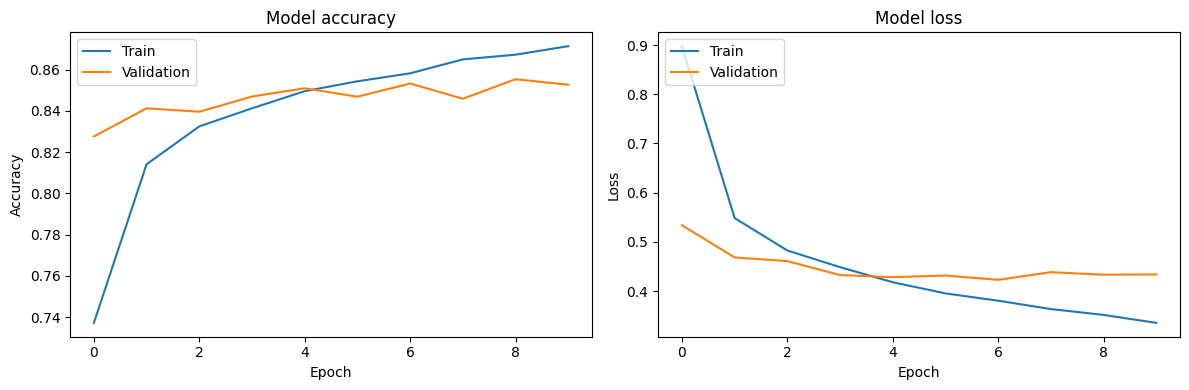

In [59]:
# Plotting the training history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [60]:
# Evaluating the CNN model on test data

# Predict classes
y_pred_cnn = model_cnn_best.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn_classes)
print(f"CNN Test Accuracy: {accuracy_cnn:.4f}")

CNN Test Accuracy: 0.8464


In [63]:
# Classification Report for CNN model

print("CNN Classification Report")
print(classification_report(y_test, y_pred_cnn_classes))

CNN Classification Report
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       976
           1       0.65      0.94      0.77      1023
           2       0.94      0.97      0.95      1003
           3       0.99      0.98      0.99      1035
           4       0.97      0.95      0.96       903
           5       0.94      0.92      0.93       928
           6       0.96      0.97      0.96       959
           7       0.98      0.98      0.98      1098
           8       0.98      0.97      0.97       941
           9       0.92      0.97      0.95       929
          10       0.91      0.95      0.93       170
          11       0.92      0.92      0.92       118
          12       0.75      0.90      0.82       316
          13       0.83      0.86      0.85       128
          14       0.96      0.90      0.93       162
          15       0.85      0.82      0.83       261
          16       0.83      0.87      0.85        60
 

e:\users\thinkpad\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\users\thinkpad\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\users\thinkpad\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


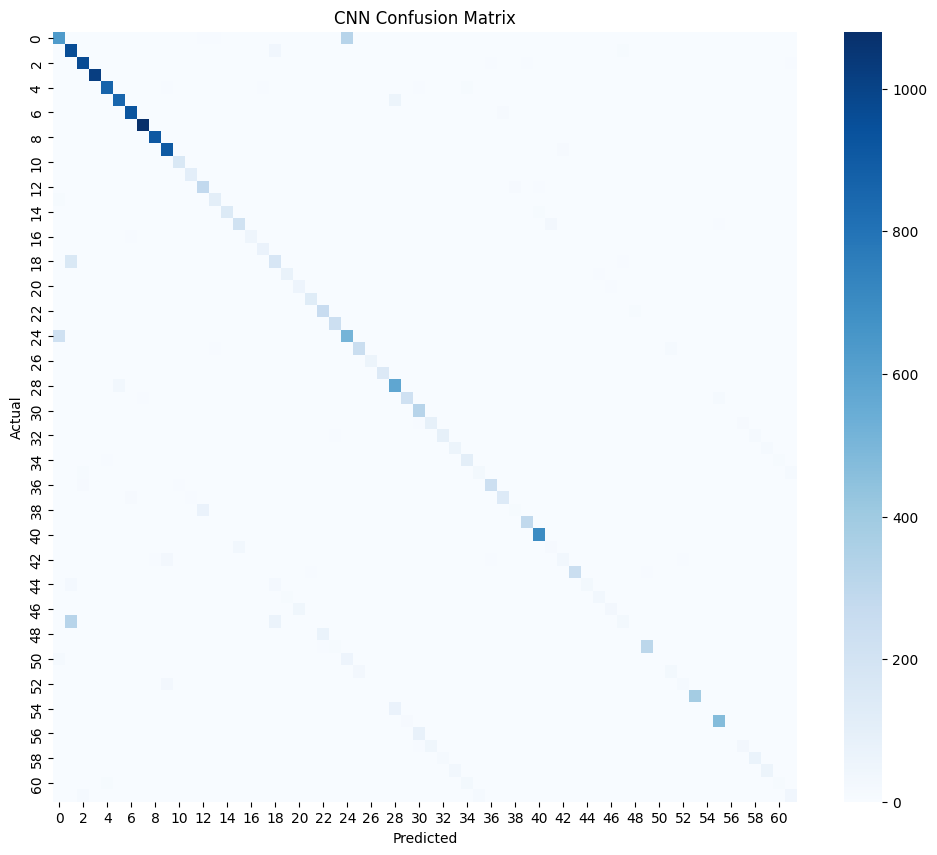

In [65]:
# Confusion Matrix for CNN model

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred_cnn_classes, "CNN Confusion Matrix")